# Explicit Feedback Neural Recommender Systems

Goals:
- Understand recommender data
- Build different models architectures using Keras
- Retrieve Embeddings and visualize them
- Add metadata information as input to the model

In [3]:
!rm -rf ml-100k ml-100k.zip

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

from pathlib import Path
from zipfile import ZipFile
from urllib.request import urlretrieve


ML_100K_URL = "http://files.grouplens.org/datasets/movielens/ml-100k.zip"
ML_100K_FILENAME = Path(ML_100K_URL.rsplit('/', 1)[1])
ML_100K_FOLDER = Path('ml-100k')

if not ML_100K_FILENAME.exists():
    print('Downloading %s to %s...' % (ML_100K_URL, ML_100K_FILENAME))
    urlretrieve(ML_100K_URL, ML_100K_FILENAME.name)

if not ML_100K_FOLDER.exists():
    print('Extracting %s to %s...' % (ML_100K_FILENAME, ML_100K_FOLDER))
    ZipFile(ML_100K_FILENAME.name).extractall('.')

Extracting ml-100k.zip to ml-100k...


### Ratings file

Each line contains a rated movie: 
- a user
- an item
- a rating from 1 to 5 stars

In [7]:
import pandas as pd
all_ratings = pd.read_csv(ML_100K_FOLDER / 'u.data', sep='\t',
                          names=["user_id", "item_id", "rating", "timestamp"])
all_ratings.head()

,user_id,item_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


### Item metadata file

The item metadata file contains metadata like the name of the movie or the date it was released

In [8]:
names = ["name", "date", "genre", "url"]
names += ["f" + str(x) for x in range(19)]  # unused feature names
items = pd.read_csv(ML_100K_FOLDER / 'u.item', sep='|', encoding='latin-1',
                    names=names)
# fix a missing value
items.fillna(value="01-Jan-1997", inplace=True)
items.head()

,name,date,genre,url,f0,f1,f2,f3,f4,f5,...,f9,f10,f11,f12,f13,f14,f15,f16,f17,f18
1,Toy Story (1995),01-Jan-1995,01-Jan-1997,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0
2,GoldenEye (1995),01-Jan-1995,01-Jan-1997,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,Four Rooms (1995),01-Jan-1995,01-Jan-1997,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,Get Shorty (1995),01-Jan-1995,01-Jan-1997,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
5,Copycat (1995),01-Jan-1995,01-Jan-1997,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


### Data preprocessing

To understand well the distribution of the data, the following statistics are computed:
- the number of users
- the number of items
- the rating distribution

In [9]:
all_ratings['rating'].describe()

count    100000.000000
mean          3.529860
std           1.125674
min           1.000000
25%           3.000000
50%           4.000000
75%           4.000000
max           5.000000
Name: rating, dtype: float64

In [10]:
max_user_id = all_ratings['user_id'].max()
max_user_id

943

In [11]:
max_item_id = all_ratings['item_id'].max()
max_item_id

1682

In [12]:
from sklearn.model_selection import train_test_split

ratings_train, ratings_test = train_test_split(
    all_ratings, test_size=0.2, random_state=0)

user_id_train = ratings_train['user_id']
item_id_train = ratings_train['item_id']
rating_train = ratings_train['rating']

user_id_test = ratings_test['user_id']
item_id_test = ratings_test['item_id']
rating_test = ratings_test['rating']
user_id_train.shape

(80000,)

# Explicit feedback: supervised ratings prediction

For each pair of (user, item) try to predict the rating the user would give to the item.

This is the classical setup for building recommender systems from offline data with explicit supervision signal. 

## Predictive ratings  as a regression problem

The following code implements the following architecture:

<img src="images/rec_archi_1.svg" style="width: 600px;" />

In [13]:
from keras.layers import Input, Embedding, Flatten, merge, Dense, Dropout, Lambda
from keras.models import Model
import keras.backend as K
from keras_fixes import dot_mode

Using TensorFlow backend.


### Note : 

- all user/items are identified by an unique integers (<=> one-hot encoding)
- For this reason the input shape must be [1]

In [14]:
# For each sample we input the integer identifiers
# of a single user and a single item
user_id_input = Input(shape=[1], name='user')
item_id_input = Input(shape=[1], name='item')

In [15]:
embedding_size = 30
user_embedding = Embedding(output_dim=embedding_size, input_dim=max_user_id + 1,
                           input_length=1, name='user_embedding')(user_id_input)
item_embedding = Embedding(output_dim=embedding_size, input_dim=max_item_id + 1,
                           input_length=1, name='item_embedding')(item_id_input)

# reshape from shape: (batch_size, input_length, embedding_size)
# to shape: (batch_size, input_length * embedding_size) which is
# equal to shape: (batch_size, embedding_size)
user_vecs = Flatten()(user_embedding)
item_vecs = Flatten()(item_embedding)

y = merge([user_vecs, item_vecs], mode=dot_mode, output_shape=(1,))

model = Model(input=[user_id_input, item_id_input], output=y)
model.compile(optimizer='adam', loss='mae')

In [16]:
# Useful for debugging the output shape of model
initial_train_preds = model.predict([user_id_train, item_id_train])
initial_train_preds

array([ 0.00435509, -0.00567379,  0.00146699, ...,  0.00260651,
       -0.00099381,  0.01268089], dtype=float32)

### Model error

Using `initial_train_preds`, compute the model errors:
- mean absolute error
- mean squared error

Converting a pandas Series to numpy array is usually implicit, but you may use `rating_train.values` to do so explicitely. Be sure to monitor the shapes of each object you deal with by using `object.shape`.

In [17]:
squared_differences = np.square(initial_train_preds - rating_train.values)
absolute_differences = np.abs(initial_train_preds - rating_train.values)

print("Random init MSE: %0.3f" % np.mean(squared_differences))
print("Random init MAE: %0.3f" % np.mean(absolute_differences))

# You may also use sklearn metrics to do so with less numpy engineering 
from sklearn.metrics import mean_squared_error, mean_absolute_error
#
print("Random init MSE: %0.3f" % mean_squared_error(initial_train_preds, rating_train))
print("Random init MAE: %0.3f" % mean_absolute_error(initial_train_preds, rating_train))

Random init MSE: 13.732
Random init MAE: 3.531
Random init MSE: 13.732
Random init MAE: 3.531


### Monitoring runs

Keras enables to monitor various variables during training. 

`history.history` returned by the `model.fit` function is a dictionary
containing the `'loss'` and validation loss `'val_loss'` after each epoch

### Note : 
- the batch_size can have a bad impact on convergence
- In order to keep in memory the convergence ==> create a new object history as below 

In [35]:
%%time
# Training the model
history = model.fit([user_id_train, item_id_train], rating_train,
                    batch_size=64, nb_epoch=6, validation_split=0.1,
                    shuffle=True)

Train on 72000 samples, validate on 8000 samples
Epoch 1/6
72000/72000 [==============================] - 5s - loss: 0.9043 - val_loss: 0.9226
Epoch 2/6
72000/72000 [==============================] - 5s - loss: 0.9044 - val_loss: 0.9229
Epoch 3/6
72000/72000 [==============================] - 5s - loss: 0.9043 - val_loss: 0.9223
Epoch 4/6
72000/72000 [==============================] - 5s - loss: 0.9043 - val_loss: 0.9222
Epoch 5/6
72000/72000 [==============================] - 5s - loss: 0.9042 - val_loss: 0.9228
Epoch 6/6
72000/72000 [==============================] - 5s - loss: 0.9042 - val_loss: 0.9234
CPU times: user 35.5 s, sys: 10.2 s, total: 45.7 s
Wall time: 32 s


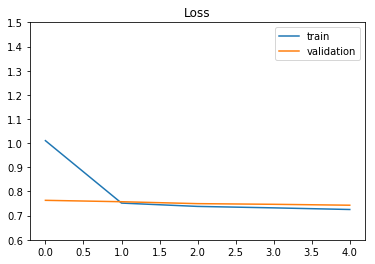

In [336]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.ylim(0.6, 1.5)
plt.legend(loc='best')
plt.title('Loss');

Now that the model is trained, the model MSE and MAE look nicer:

### Note : 

- MAE is better in terms of interpretation because it belongs to the same magnitude of ratings

In [42]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

test_preds = model.predict([user_id_test, item_id_test])
print("Final test MSE: %0.3f" % mean_squared_error(test_preds, rating_test))
print("Final test MAE: %0.3f" % mean_absolute_error(test_preds, rating_test))

Final test MSE: 1.423
Final test MAE: 0.901


In [43]:
train_preds = model.predict([user_id_train, item_id_train])
print("Final train MSE: %0.3f" % mean_squared_error(train_preds, rating_train))
print("Final train MAE: %0.3f" % mean_absolute_error(train_preds, rating_train))

Final train MSE: 1.411
Final train MAE: 0.900


## A Deep recommender model

Using a similar framework as previously, the following deep model described in the course was built (with only two fully connected)

<img src="images/rec_archi_2.svg" style="width: 600px;" />


### Exercise

- The following code has **4 errors** that prevent it from working correctly. **Correct them and explain** why they are critical.

The model is underfitting , Why ? 

Were are using a tanh output layer : 

We want to predict a output of range(0,5) ==> fail

Note : 

- We could do as an output layer

In [67]:
# For each sample we input the integer identifiers
# of a single user and a single item
user_id_input = Input(shape=[1], name='user') 
item_id_input = Input(shape=[1], name='item')

embedding_size = 30
user_embedding = Embedding(output_dim=embedding_size, input_dim=max_user_id + 1,
                           input_length=1, name='user_embedding')(user_id_input)
item_embedding = Embedding(output_dim=embedding_size, input_dim=max_item_id + 1,
                           input_length=1, name='item_embedding')(item_id_input)

# reshape from shape: (batch_size, input_length, embedding_size)
# to shape: (batch_size, input_length * embedding_size) which is
# equal to shape: (batch_size, embedding_size)
user_vecs = Flatten()(user_embedding)
item_vecs = Flatten()(item_embedding)
input_vecs = merge([user_vecs, item_vecs], mode='concat')
input_vecs = Dropout(0.5)(input_vecs)

x = Dense(64, activation='relu')(input_vecs)
y = Dense(1)(x) # better !!
#y = Dense(2, activation='tanh')(x)
print("user input",user_id_input.get_shape)
print("user embedding",user_embedding.get_shape)
print("user vecs",user_vecs.get_shape)
print("input merged",input_vecs.get_shape)



model = Model(input=[user_id_input, item_id_input], output=y)
model.compile(optimizer='adam', loss='mae')

initial_train_preds = model.predict([user_id_train, item_id_train])

user input <bound method Tensor.get_shape of <tf.Tensor 'user_15:0' shape=(?, 1) dtype=float32>>
user embedding <bound method Tensor.get_shape of <tf.Tensor 'Gather_21:0' shape=(?, 1, 30) dtype=float32>>
user vecs <bound method Tensor.get_shape of <tf.Tensor 'Reshape_20:0' shape=(?, ?) dtype=float32>>
input merged <bound method Tensor.get_shape of <tf.Tensor 'cond_6/Merge:0' shape=(?, ?) dtype=float32>>


In [80]:
%%time
history = model.fit([user_id_train, item_id_train], rating_train,
                    batch_size=64, nb_epoch=5, validation_split=0.1,
                    shuffle=True)

Train on 72000 samples, validate on 8000 samples
Epoch 1/5
72000/72000 [==============================] - 8s - loss: 1.0104 - val_loss: 0.7634
Epoch 2/5
72000/72000 [==============================] - 7s - loss: 0.7520 - val_loss: 0.7576
Epoch 3/5
72000/72000 [==============================] - 7s - loss: 0.7382 - val_loss: 0.7496
Epoch 4/5
72000/72000 [==============================] - 7s - loss: 0.7322 - val_loss: 0.7469
Epoch 5/5
72000/72000 [==============================] - 7s - loss: 0.7254 - val_loss: 0.7432
CPU times: user 40.1 s, sys: 19.3 s, total: 59.3 s
Wall time: 38.8 s


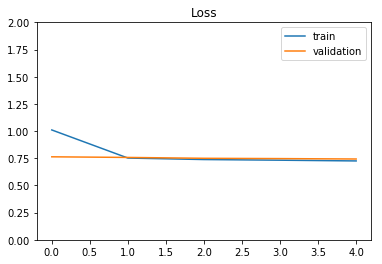

In [81]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.ylim(0, 2)
plt.legend(loc='best')
plt.title('Loss');

In [82]:
test_preds = model.predict([user_id_test, item_id_test])
print("Final test MSE: %0.3f" % mean_squared_error(test_preds, rating_test))
print("Final test MAE: %0.3f" % mean_absolute_error(test_preds, rating_test))

print("Final train MSE: %0.3f" % mean_squared_error(train_preds, rating_train))
print("Final train MAE: %0.3f" % mean_absolute_error(train_preds, rating_train))

Final test MSE: 0.917
Final test MAE: 0.731
Final train MSE: 13.765
Final train MAE: 3.535


### Home assignment: 
 - Add another layer, compare train/test error
 - What do you notice? 
 - Try adding more dropout and modifying layer sizes: should you increase
   or decrease the number of parameters

In [75]:
user_id_input_2 = Input(shape=[1], name='user') 
item_id_input_2 = Input(shape=[1], name='item')

embedding_size = 30
user_embedding_2 = Embedding(output_dim=embedding_size, input_dim=max_user_id + 1,
                           input_length=1, name='user_embedding')(user_id_input_2)
item_embedding_2 = Embedding(output_dim=embedding_size, input_dim=max_item_id + 1,
                           input_length=1, name='item_embedding')(item_id_input_2)

# reshape from shape: (batch_size, input_length, embedding_size)
# to shape: (batch_size, input_length * embedding_size) which is
# equal to shape: (batch_size, embedding_size)
user_vecs_2 = Flatten()(user_embedding_2)
item_vecs_2 = Flatten()(item_embedding_2)
input_vecs_2 = merge([user_vecs_2, item_vecs_2], mode='concat')
input_vecs_2 = Dropout(0.5)(input_vecs_2)

x_2 = Dense(64, activation='relu')(input_vecs_2)

# adding another dense layer with relu activation 128 weights
x_2_2 = Dense(128, activation='relu')(x_2)

y_2 = Dense(1)(x_2_2) 

print("user input",user_id_input_2.get_shape)
print("user embedding",user_embedding_2.get_shape)
print("user vecs",user_vecs_2.get_shape)
print("input merged",input_vecs_2.get_shape)



model_2 = Model(input=[user_id_input_2, item_id_input_2], output=y_2)
model_2.compile(optimizer='adam', loss='mae')

initial_train_preds_2 = model_2.predict([user_id_train, item_id_train])
print(initial_train_preds_2.shape)

user input <bound method Tensor.get_shape of <tf.Tensor 'user_22:0' shape=(?, 1) dtype=float32>>
user embedding <bound method Tensor.get_shape of <tf.Tensor 'Gather_35:0' shape=(?, 1, 30) dtype=float32>>
user vecs <bound method Tensor.get_shape of <tf.Tensor 'Reshape_34:0' shape=(?, ?) dtype=float32>>
input merged <bound method Tensor.get_shape of <tf.Tensor 'cond_13/Merge:0' shape=(?, ?) dtype=float32>>
(80000, 1)


In [83]:
history_2 = model_2.fit([user_id_train, item_id_train], rating_train,
                    batch_size=64, nb_epoch=5, validation_split=0.1,
                    shuffle=True)

Train on 72000 samples, validate on 8000 samples
Epoch 1/5
72000/72000 [==============================] - 8s - loss: 0.7266 - val_loss: 0.7519
Epoch 2/5
72000/72000 [==============================] - 8s - loss: 0.7200 - val_loss: 0.7487
Epoch 3/5
72000/72000 [==============================] - 8s - loss: 0.7138 - val_loss: 0.7410
Epoch 4/5
72000/72000 [==============================] - 8s - loss: 0.7072 - val_loss: 0.7383
Epoch 5/5
72000/72000 [==============================] - 8s - loss: 0.7019 - val_loss: 0.7361


In [191]:
test_preds_2 = model_2.predict([user_id_test, item_id_test])
test_preds = model.predict([user_id_test, item_id_test])
train_preds_2 = model_2.predict([user_id_train, item_id_train])
train_preds = model.predict([user_id_train, item_id_train])
print("Model 2 ","Final test MSE: %0.3f" % mean_squared_error(test_preds_2, rating_test),"Final train MSE: %0.3f" % mean_squared_error(train_preds_2, rating_train))
print("Model 1 ","Final test MSE: %0.3f" % mean_squared_error(test_preds, rating_test),"Final train MSE: %0.3f" % mean_squared_error(train_preds, rating_train))
print("Model 2 ","Final test MAE: %0.3f" % mean_absolute_error(test_preds_2, rating_test),"Final train MAE: %0.3f" % mean_absolute_error(train_preds_2, rating_train))
print("Model 1 ","Final test MAE: %0.3f" % mean_absolute_error(test_preds, rating_test),"Final train MAE: %0.3f" % mean_absolute_error(train_preds, rating_train))

Model 2  Final test MSE: 0.926 Final train MSE: 0.837
Model 1  Final test MSE: 0.917 Final train MSE: 0.858
Model 2  Final test MAE: 0.721 Final train MAE: 0.676
Model 1  Final test MAE: 0.731 Final train MAE: 0.700


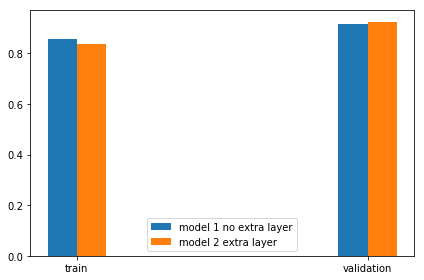

In [211]:
width = 0.1
train_error_1 = float("%.3f" %mean_squared_error(train_preds, rating_train))
valid_error_1 = float("%.3f" %mean_squared_error(test_preds, rating_test))
train_error_2 = float("%.3f" %mean_squared_error(train_preds_2, rating_train))
valid_error_2 = float("%.3f" %mean_squared_error(test_preds_2, rating_test))
plot = plt.bar(np.arange(2),(train_error_1,valid_error_1),width=width,label="model 1 no extra layer")
plot2 = plt.bar(np.arange(2)+width,(train_error_2,valid_error_2),width=width,label="model 2 extra layer")
plt.xticks(np.arange(2) + width / 2, ('train', 'validation'))
plt.tight_layout()
plt.legend()
plt.show()

## Interpretation : 

- If the result plotted are true then the model with an extra layer is clearly overfitting the data

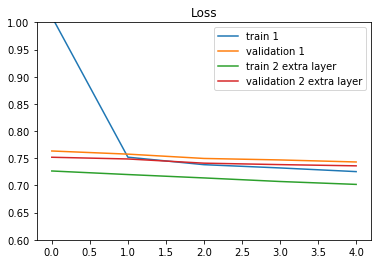

In [115]:
plt.plot(history.history['loss'], label='train 1')
plt.plot(history.history['val_loss'], label='validation 1')
plt.plot(history_2.history['loss'], label='train 2 extra layer')
plt.plot(history_2.history['val_loss'], label='validation 2 extra layer')
plt.ylim(0.6,1 )
#plt.yscale("log")
plt.legend(loc='best')
plt.title('Loss');

In [225]:
a = ()
a+(23,213)

(23, 213)

In [242]:
user_id_input_comparison = Input(shape=[1], name='user') 
item_id_input_comparison = Input(shape=[1], name='item')
embedding_size = 30
number_hidden_neurons_extra_layer =120

def comparison_extra_layer(number_hidden_neurons_extra_layer_list):
    test_pred_comparison_list = []
    train_preds_comparison_list = []
    for number_hidden_neurons_extra_layer in number_hidden_neurons_extra_layer_list : 
        user_embedding_comparison = Embedding(output_dim=embedding_size, input_dim=max_user_id + 1,
                           input_length=1, name='user_embedding')(user_id_input_comparison)
        item_embedding_comparison = Embedding(output_dim=embedding_size, input_dim=max_item_id + 1,
                           input_length=1, name='item_embedding')(item_id_input_comparison)
# reshape from shape: (batch_size, input_length, embedding_size)
# to shape: (batch_size, input_length * embedding_size) which is
# equal to shape: (batch_size, embedding_size)
        user_vecs_comparison = Flatten()(user_embedding_comparison)
        item_vecs_comparison = Flatten()(item_embedding_comparison)
        input_vecs_comparison = merge([user_vecs_comparison, item_vecs_comparison], mode='concat')
        input_vecs_comparison = Dropout(0.5)(input_vecs_comparison)
        x_comparison = Dense(64, activation='relu')(input_vecs_comparison)
# adding another dense layer with relu activation 128 weights
        x_2_comparison = Dense(number_hidden_neurons_extra_layer, activation='relu')(x_comparison)
        y_comparison = Dense(1)(x_2_comparison) 

        model_comparison = Model(input=[user_id_input_2, item_id_input_2], output=y_2)
        model_comparison.compile(optimizer='adam', loss='mae')
        history_comparison = model_comparison.fit([user_id_train, item_id_train], rating_train,
                    batch_size=64, nb_epoch=5, validation_split=0.1,
                    shuffle=True)
         
        train = float("%.3f" %mean_squared_error(model_comparison.predict([user_id_train, item_id_train]), rating_train))
        test = float("%.3f" %mean_squared_error(model_comparison.predict([user_id_test, item_id_test]), rating_test))
        test_pred_comparison_list.append(test)
        train_preds_comparison_list.append(train)
    return train_preds_comparison_list, test_pred_comparison_list

In [423]:
extra_units_list = [24,48,96,192]
train, test = comparison_extra_layer(extra_units_list)

Train on 72000 samples, validate on 8000 samples
Epoch 1/5
72000/72000 [==============================] - 11s - loss: 0.6388 - val_loss: 0.7228
Epoch 2/5
72000/72000 [==============================] - 9s - loss: 0.6388 - val_loss: 0.7267
Epoch 3/5
72000/72000 [==============================] - 9s - loss: 0.6405 - val_loss: 0.7231
Epoch 4/5
72000/72000 [==============================] - 8s - loss: 0.6405 - val_loss: 0.7268
Epoch 5/5
72000/72000 [==============================] - 9s - loss: 0.6388 - val_loss: 0.7243
Train on 72000 samples, validate on 8000 samples
Epoch 1/5
72000/72000 [==============================] - 11s - loss: 0.6388 - val_loss: 0.7232
Epoch 2/5
72000/72000 [==============================] - 9s - loss: 0.6405 - val_loss: 0.7265
Epoch 3/5
72000/72000 [==============================] - 9s - loss: 0.6404 - val_loss: 0.7225
Epoch 4/5
72000/72000 [==============================] - 9s - loss: 0.6371 - val_loss: 0.7240
Epoch 5/5
72000/72000 [==============================]

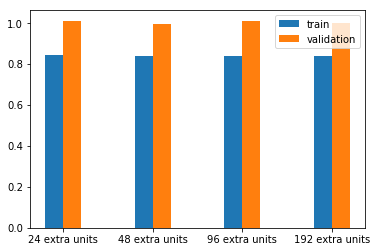

In [424]:
width = 0.2
train
plot = plt.bar(np.arange(4),train,width=width,label="train")
plot2 = plt.bar(np.arange(4)+width,test,width=width,label="validation")
plt.xticks(np.arange(4) + width / 2, [str(e)+" extra units" for e in extra_units_list])
#plt.tight_layout()
plt.legend()
plt.show()

### What to do : 
- Present the results with barplots Ok ich
- Present the convergence overlaying on the same graph : ok ich
- Present a comparison (through a bar plot for instance) with the test/train error in regard to the number of hidden neurons within the new hidden layer  ok ich
- Intepret more clearly the result ? and do the same with drop out ==> GRID dropout x number_extra_hidden_units ? 

### Model Embeddings

- It is possible to retrieve the embeddings by simply using the Keras function `model.get_weights` which returns all the model learnable parameters.
- The weights are returned the same order as they were build in the model
- What is the total number of parameters?

In [279]:
# weights and shape
weights = model.get_weights()
print([w.shape for w in weights])
# good things to check if everything is correct (cf. EXAM !!)
def compute_total_number_parameters(weights = model.get_weights()):
    total_number_of_parameters = 0
    for w in weights:
        #for i in range(1):
        if len(w.shape)>1: total_number_of_parameters +=w.shape[0]*w.shape[1]
        else: total_number_of_parameters +=w.shape[0]
    return total_number_of_parameters

print("Total number of parameters %0.0f" % compute_total_number_parameters())

[(944, 30), (1683, 30), (60, 64), (64,), (64, 1), (1,)]
Total number of parameters 82779


In [280]:
model.summary()

In [283]:
print(len(weights))
user_embeddings = weights[0]
item_embeddings = weights[1]
print("First item name from metadata:", items["name"][1])
print("Embedding vector for the first item:")
print(item_embeddings[1])
print("shape:", item_embeddings[1].shape)

6
First item name from metadata: Toy Story (1995)
Embedding vector for the first item:
[-0.153706    0.02782148 -0.0666879   0.00895518  0.04147837  0.05483565
 -0.10099007 -0.03408018 -0.03266044 -0.11683965  0.03057031  0.11805814
  0.11697408 -0.00268501 -0.02205011  0.08555336 -0.03463333 -0.06418615
 -0.04046222 -0.03841777 -0.0249313  -0.1118601   0.01167009 -0.00356281
  0.06080368  0.00399638  0.06414735  0.0322365  -0.06465223 -0.03773543]
shape: (30,)


### Note : 
- Hence, we managed to transform a one-hot encoding into a dense dimensons 30 space
- We are here learning the best item/user embedding so that the target recquirement are satisfied (embedding space is in a way that close user-item are close in the space and far user-item are far)

### Finding most similar items
Finding k most similar items to a point in embedding space

- Write in numpy a function to compute the cosine similarity between two points in embedding space
- Write a function which computes the euclidean distance between a point in embedding space and all other points
- Write a most similar function, which returns the k item names with lowest euclidean distance
- Try with a movie index, such as 181 (Return of the Jedi). What do you observe? Don't expect miracles on such a small training set.

Notes:
- you may use `np.linalg.norm` to compute the norm of vector, and you may specify the `axis=`
- the numpy function `np.argsort(...)` enables to compute the sorted indices of a vector
- `items["name"][idxs]` returns the names of the items indexed by array idxs

### Note :
- Keep in mind that the higher the cosine distance the more similar items are
- In opposition with euclidian distance

In [337]:
EPSILON = 1e-07

# the result is a 1d array of cosine distance between each item and x
def cosine(x):
    dot_pdts = np.dot(item_embeddings, x)
    norms = np.linalg.norm(x) * np.linalg.norm(item_embeddings, axis=1)
    return dot_pdts / (norms + EPSILON) 
# the result is a 1d array of euclidian distance between each item and xdef euclidean_distances(x):
def euclidean_distances(x):
    return np.linalg.norm(item_embeddings - x, axis=1)

# Computes top_n most similar items to an idx
def most_similar(idx, top_n=10,distance=cosine):
    # TODO: modify function
    if distance==cosine: 
        idxs = np.argsort(distance(item_embeddings[idx,:]))[::-1][0:top_n]
    else : 
        idxs = np.argsort(distance(item_embeddings[idx,:]))[0:top_n]
    return items["name"][idxs]

print("Distance cosine 3 closest movies \n",most_similar(181,top_n=3,distance=cosine))
print(" ")
print("Distance euclidian 3 closest movies \n",most_similar(181,top_n=3,distance=euclidean_distances))

Distance cosine 3 closest movies 
 181     Return of the Jedi (1983)
179    Clockwork Orange, A (1971)
285         Secrets & Lies (1996)
Name: name, dtype: object
 
Distance euclidian 3 closest movies 
 181    Return of the Jedi (1983)
632       Sophie's Choice (1982)
498    African Queen, The (1951)
Name: name, dtype: object


In [338]:
# correction 
def most_similar2(idx, top_n=10, mode='euclidean'):
    sorted_indexes=0
    if mode=='euclidean':
        dists = euclidean_distances(item_embeddings[idx])
        sorted_indexes = np.argsort(dists)
        idxs = sorted_indexes[0:top_n]
        return list(zip(items["name"][idxs], dists[idxs]))
    else:
        sims = cosine(item_embeddings[idx])
        # [::-1] makes it possible to reverse the order of a numpy
        # array, this is required because most similar items have
        # a larger cosine similarity value
        sorted_indexes = np.argsort(sims)[::-1]
        idxs = sorted_indexes[0:top_n]
        return list(zip(items["name"][idxs], sims[idxs]))
most_similar2(181, top_n=3,mode="cosine")

[('Return of the Jedi (1983)', 0.99999946),
 ('Clockwork Orange, A (1971)', 0.90321898),
 ('Secrets & Lies (1996)', 0.88905501)]

### Visualizing embeddings using TSNE

- we use scikit learn to visualize items embeddings
- Try different perplexities, and visualize user embeddings as well
- What can you conclude ?

In [55]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

### Note : Quick Description of t-SNE
-  t-SNE is a more efficient way to do vualization based on SNE : Stochastic Neighbor Embedding.
-  SNE relies on a few assumtpions 
    - SNE models the similarity of two observations or two embeddings as a conditional distribution following a gaussian distribution. 
    - Then the objective is to minimize the kullback divergence of those two similarity distributions (the real one and the embedding one)
    - The perpexity is an hyperparameter that allows to constraint the value of the variance of the similarities of the real data. $2^H(Pi)$
- In order to solve the "crowding problem" and the difficult to optimize objective of SNE, t-SNE replaces the similarities distribution with a student distribution and the cost with a symmetric form of the Kullback

In [395]:
item_tsne_1 = TSNE(perplexity=1).fit_transform(item_embeddings)
item_tsne_10 = TSNE(perplexity=10).fit_transform(item_embeddings)
item_tsne_30 = TSNE(perplexity=60).fit_transform(item_embeddings)
item_tsne_120 = TSNE(perplexity=100).fit_transform(item_embeddings)

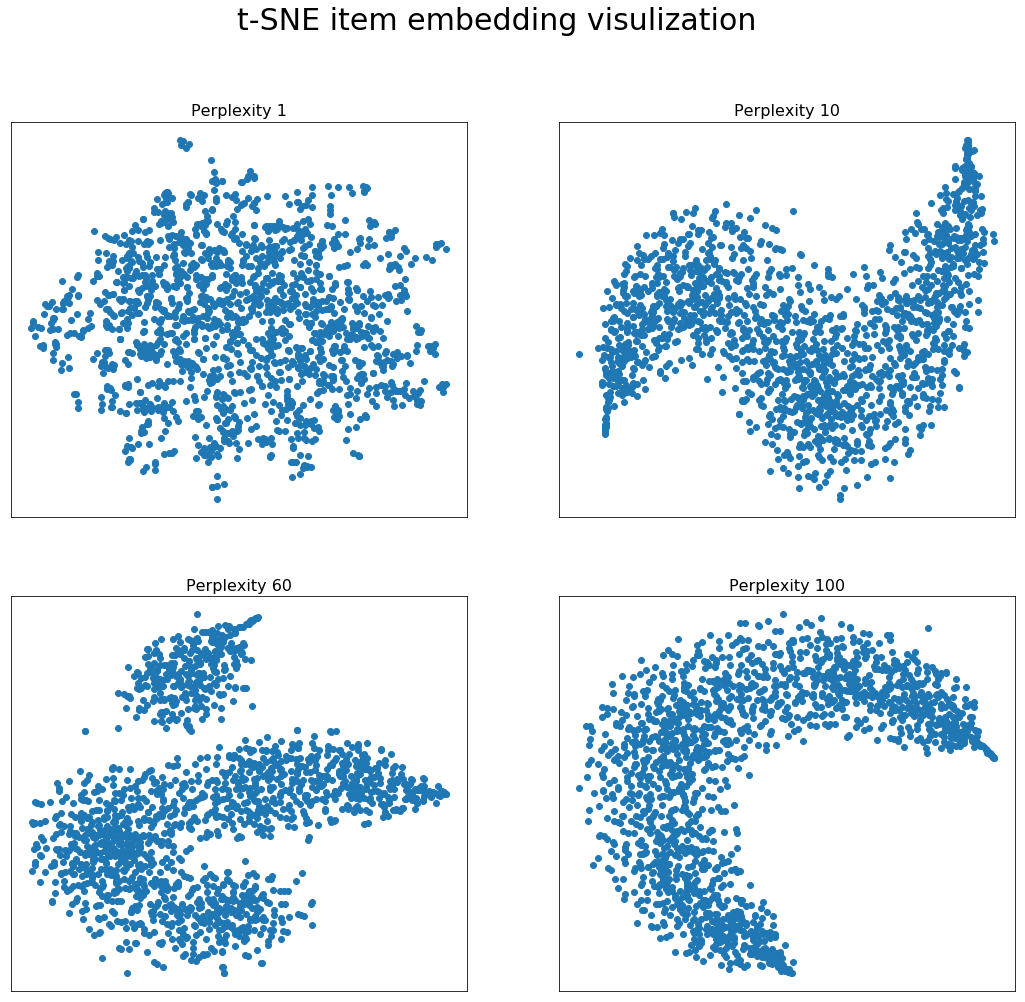

In [398]:
plt.figure(figsize=(18.0, 16.0))
plt.suptitle("t-SNE item embedding visulization",fontsize=30)
plt.subplot(2, 2, 1)
plt.scatter(item_tsne_1[:, 0], item_tsne_1[:, 1]);
plt.xticks(()); plt.yticks(());
plt.title("Perplexity 1", fontsize=16)
#plt.ylim([-2, 2])
plt.subplot(2, 2, 2)
plt.scatter(item_tsne_30[:, 0], item_tsne_30[:, 1]);
plt.xticks(()); plt.yticks(());
plt.title("Perplexity 10", fontsize=16)
#plt.ylim([-2, 2])
plt.subplot(2, 2, 3)
plt.scatter(item_tsne_50[:, 0], item_tsne_50[:, 1]);
plt.xticks(()); plt.yticks(());
plt.title("Perplexity 60", fontsize=16)
#plt.ylim([-2, 2])
plt.subplot(2, 2, 4)
plt.scatter(item_tsne_100[:, 0], item_tsne_100[:, 1]);
plt.xticks(()); plt.yticks(());
plt.title("Perplexity 100", fontsize=16)

## Perplexity impact : 
- Below a certain threshold the embedding has no specific shape ==> bad visualization 
- Above a certain threshold (around 100) the embedding does not change regarding the perplexity parameter
- Around 50 we distinguish a clear shapes in the embedding

## Using item metadata in the model

Using a similar framework as previously, we will build another deep model that can also leverage additional metadata. The resulting system is therefore an **Hybrid Recommender System** that does both **Collaborative Filtering** and **Content-based recommendations**.

<img src="images/rec_archi_3.svg" style="width: 600px;" />


In [403]:
# transform the date (string) into an int representing the release year
parsed_dates = [int(film_date[-4:])
                for film_date in items["date"].tolist()]

items['parsed_date'] = pd.Series(parsed_dates, index=items.index)
max_date = max(items['parsed_date'])
min_date = min(items['parsed_date'])

from sklearn.preprocessing import scale

items['scaled_date'] = scale(items['parsed_date'].astype('float64'))
item_meta_train = items["scaled_date"][item_id_train]
item_meta_test = items["scaled_date"][item_id_test]

len(item_meta_train), len(item_meta_test)

(80000, 20000)

In [404]:
items["scaled_date"].describe()

count    1.682000e+03
mean    -2.415758e-15
std      1.000297e+00
min     -4.730390e+00
25%      2.533563e-01
50%      3.937435e-01
75%      4.639372e-01
max      6.043244e-01
Name: scaled_date, dtype: float64

### Note : 

- We add a scaled version of the release date for each movie 
- We input it after the embedding layer using the merge("concat") function 

In [406]:
# For each sample we input the integer identifiers
# of a single user and a single item
user_id_input = Input(shape=[1], name='user')
item_id_input = Input(shape=[1], name='item')
meta_input = Input(shape=[1], name='meta_item')

embedding_size = 32
user_embedding = Embedding(output_dim=embedding_size, input_dim=max_user_id + 1,
                           input_length=1, name='user_embedding')(user_id_input)
item_embedding = Embedding(output_dim=embedding_size, input_dim=max_item_id + 1,
                           input_length=1, name='item_embedding')(item_id_input)


# reshape from shape: (batch_size, input_length, embedding_size)
# to shape: (batch_size, input_length * embedding_size) which is
# equal to shape: (batch_size, embedding_size)
user_vecs = Flatten()(user_embedding)
item_vecs = Flatten()(item_embedding)

input_vecs = merge([user_vecs, item_vecs, meta_input], mode='concat')

x = Dense(64, activation='relu')(input_vecs)
x = Dropout(0.5)(x)
x = Dense(32, activation='relu')(x)
y = Dense(1)(x)

model_metadata = Model(input=[user_id_input, item_id_input, meta_input], output=y)
model_metadata.compile(optimizer='adam', loss='mae')

initial_train_preds = model_metadata.predict([user_id_train, item_id_train, item_meta_train])

In [407]:
%%time
history = model_metadata.fit([user_id_train, item_id_train, item_meta_train], rating_train,
                    batch_size=64, nb_epoch=15, validation_split=0.1,
                    shuffle=True)

Train on 72000 samples, validate on 8000 samples
Epoch 1/15
72000/72000 [==============================] - 12s - loss: 0.9649 - val_loss: 0.7719
Epoch 2/15
72000/72000 [==============================] - 10s - loss: 0.7632 - val_loss: 0.7553
Epoch 3/15
72000/72000 [==============================] - 9s - loss: 0.7375 - val_loss: 0.7459
Epoch 4/15
72000/72000 [==============================] - 9s - loss: 0.7153 - val_loss: 0.7371
Epoch 5/15
72000/72000 [==============================] - 10s - loss: 0.6986 - val_loss: 0.7277
Epoch 6/15
72000/72000 [==============================] - 9s - loss: 0.6837 - val_loss: 0.7276
Epoch 7/15
72000/72000 [==============================] - 10s - loss: 0.6735 - val_loss: 0.7230
Epoch 8/15
72000/72000 [==============================] - 10s - loss: 0.6653 - val_loss: 0.7273
Epoch 9/15
72000/72000 [==============================] - 10s - loss: 0.6582 - val_loss: 0.7265
Epoch 10/15
72000/72000 [==============================] - 10s - loss: 0.6532 - val_loss: 

In [428]:
train_preds_metadata = model_metadata.predict([user_id_train, item_id_train, item_meta_train])
test_preds_metadata = model_metadata.predict([user_id_test, item_id_test, item_meta_test])
print("Final test Loss: %0.3f" % mean_squared_error(test_preds_metadata, rating_test))
print("Final test Loss: %0.3f" % mean_absolute_error(test_preds_metadata, rating_test))

Final test Loss: 0.968
Final test Loss: 0.718


In [481]:
train_withMeta = train.copy()
test_withMeta = test.copy()
print(train_withMeta)
labels =[str(e)+" extra units" for e in extra_units_list]
labels.append("with meta data")
print(labels)
#train_withMeta.append(mean_squared_error(train_preds_metadata, rating_train))
#test_withMeta.append(mean_squared_error(test_preds_metadata, rating_test))
print(train_withMeta)

[0.843, 0.839, 0.841, 0.838, 0.792]
['24 extra units', '48 extra units', '96 extra units', '192 extra units', 'with meta data']
[0.843, 0.839, 0.841, 0.838, 0.792]


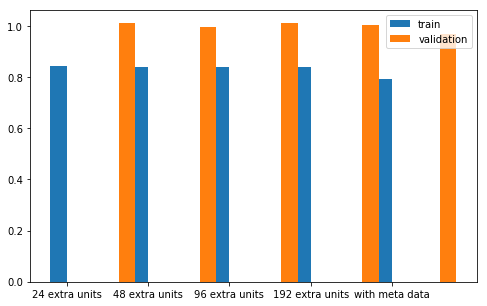

In [480]:
width = 0.2
plt.figure(figsize=(8.0,5.0))
plot = plt.bar(np.arange(5),train_withMeta,width=width,label="train")
plot2 = plt.bar(np.arange(5)+train_withMeta,test_withMeta,width=width,label="validation")
plt.xticks(np.arange(5) + width / 2, labels)
#plt.tight_layout()
plt.legend()
plt.show()

### A recommendation function for a given user

Once the model is trained, the system can be used to recommend a few items for a user, that he/she hasn't already seen:
- we use the `model.predict` to compute the ratings a user would have given to all items
- we build a reco function that sorts these items and exclude those the user has already seen

In [500]:
def recommend(user_id, top_n=10):
    item_ids = range(1, max_item_id)
    seen_movies = list(all_ratings[all_ratings["user_id"]==user_id]["item_id"])
    item_ids = list(filter(lambda x: x not in seen_movies, item_ids))
    
    print("user "+str(user_id) +" has seen "+str(len(seen_movies)) + " movies. "+
          "Computing ratings for "+str(len(item_ids))+ " other movies")
    
    item_ids = np.array(item_ids)
    user = np.zeros_like(item_ids)
    user[:]=user_id
    items_meta = items["scaled_date"][item_ids].values
    
    rating_preds = model.predict([user, item_ids, items_meta])
    
    item_ids = np.argsort(rating_preds[:,0])[::-1].tolist()
    rec_items = item_ids[:top_n]
    return [(items["name"][movie], rating_preds[movie][0]) for movie in rec_items]

In [501]:
recommend(3)

user 3 has seen 54 movies. Computing ratings for 1627 other movies


[('Full Speed (1996)', 0.15444106),
 ('Hunted, The (1995)', 0.15105651),
 ('Garden of Finzi-Contini, The (Giardino dei Finzi-Contini, Il) (1970)',
  0.14801937),
 ('Braindead (1992)', 0.14751455),
 ('Aparajito (1956)', 0.14686759),
 ('Hush (1998)', 0.14406794),
 ('B*A*P*S (1997)', 0.14302236),
 ('Paris Was a Woman (1995)', 0.14237665),
 ('Everest (1998)', 0.14170744),
 ('One Fine Day (1996)', 0.14073014)]

### Home assignment: Predicting ratings as a classification problem

In this dataset, the ratings all belong to a finite set of possible values:

In [62]:
import numpy as np
np.unique(rating_train)

array([1, 2, 3, 4, 5])

Maybe we can help the model by forcing it to predict those values by treating the problem as a multiclassification problem. The only required changes are:

- setting the final layer to output class membership probabities using a softmax activation with 5 outputs;
- optimize the categorical cross-entropy classification loss instead of a regression loss such as MSE or MAE.

In [ ]:
user_id_input = Input(shape=[1], name='user') 
item_id_input = Input(shape=[1], name='item')

embedding_size = 30
user_embedding = Embedding(output_dim=embedding_size, input_dim=max_user_id + 1,
                           input_length=1, name='user_embedding')(user_id_input)
item_embedding = Embedding(output_dim=embedding_size, input_dim=max_item_id + 1,
                           input_length=1, name='item_embedding')(item_id_input)

# reshape from shape: (batch_size, input_length, embedding_size)
# to shape: (batch_size, input_length * embedding_size) which is
# equal to shape: (batch_size, embedding_size)
user_vecs = Flatten()(user_embedding)
item_vecs = Flatten()(item_embedding)
input_vecs = merge([user_vecs, item_vecs], mode='concat')
input_vecs = Dropout(0.5)(input_vecs)

x = Dense(64, activation='relu')(input_vecs)
y = Dense(1)(x) # better !!
#y = Dense(2, activation='tanh')(x)
print("user input",user_id_input.get_shape)
print("user embedding",user_embedding.get_shape)
print("user vecs",user_vecs.get_shape)
print("input merged",input_vecs.get_shape)



model = Model(input=[user_id_input, item_id_input], output=y)
model.compile(optimizer='adam', loss='mae')

initial_train_preds = model.predict([user_id_train, item_id_train])

## Note : 
- as our target is a 1 dim array of intergers betwwen 1 and 5, we use a loss of sparse_categorical_crossentropy
- this loss is equivalent to adding a transformation of 1-hot encoded layer for the target 

In [497]:
user_id_input_2 = Input(shape=[1], name='user') 
item_id_input_2 = Input(shape=[1], name='item')

embedding_size = 30
user_embedding_2 = Embedding(output_dim=embedding_size, input_dim=max_user_id + 1,
                           input_length=1, name='user_embedding')(user_id_input_2)
item_embedding_2 = Embedding(output_dim=embedding_size, input_dim=max_item_id + 1,
                           input_length=1, name='item_embedding')(item_id_input_2)

# reshape from shape: (batch_size, input_length, embedding_size)
# to shape: (batch_size, input_length * embedding_size) which is
# equal to shape: (batch_size, embedding_size)
user_vecs_2 = Flatten()(user_embedding_2)
item_vecs_2 = Flatten()(item_embedding_2)
input_vecs_2 = merge([user_vecs_2, item_vecs_2], mode='concat')
input_vecs_2 = Dropout(0.5)(input_vecs_2)
x_2 = Dense(64, activation='relu')(input_vecs_2)
# adding another dense layer with softmax in order to do multiclass prediction
x_2_2 = Dense(activation='softmax',output_dim=5)(x_2)

model_softmax = Model(input=[user_id_input_2, item_id_input_2], output=x_2_2)
model_softmax.compile(optimizer='adam', loss='sparse_categorical_crossentropy')

initial_train_pred_softmax = model_softmax.predict([user_id_train, item_id_train])

In [499]:
model_softmax.fit([user_id_train, item_id_train], rating_train-1,
                    batch_size=64, nb_epoch=5, validation_split=0.1,
                    shuffle=True)

Train on 72000 samples, validate on 8000 samples
Epoch 1/5
72000/72000 [==============================] - 9s - loss: 1.3526 - val_loss: 1.2818
Epoch 2/5
72000/72000 [==============================] - 8s - loss: 1.2580 - val_loss: 1.2695
Epoch 3/5
72000/72000 [==============================] - 8s - loss: 1.2384 - val_loss: 1.2654
Epoch 4/5
72000/72000 [==============================] - 8s - loss: 1.2263 - val_loss: 1.2603
Epoch 5/5
72000/72000 [==============================] - 8s - loss: 1.2157 - val_loss: 1.2597
